In [1]:
# Nhập thư viện
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Chúng ta đọc dữ liệu của Corpus
corpus = pd.read_csv('data/cleaned_mhc.csv')

# In ra một vài điểm dữ liệu đầu tiên
print(corpus.head(20))

# In ra shape của DataFrame
print("\nShape of the DataFrame:", corpus.shape)

# In ra thông tin về DataFrame
print(corpus.info())

                                                 text  label
0   dear american teen question dutch person heard...      0
1   nothing look forward life dont many reason kee...      1
2   music recommendation im looking expand playlis...      0
3   im done trying feel reason im still alive know...      1
4   worried year old girl subject domestic going l...      1
5   hey rredflag sure right place post go im curre...      1
6   feel like someone need hear tonight feeling ri...      0
7   deserve died right noone would care real frien...      1
8   feel good ive set killing friday nice finally ...      1
9   live made stupid random choice getting basical...      1
10  motivated ngl cant wait get shape know gonna o...      0
11  know youd rather laid big booty body hella pos...      0
12  usual hollywood everyone movie one classic upt...      0
13  think nearly unbelievable film could made deat...      0
14  guy coming sure wear hey guy friend coming tom...      0
15  one best episode ent

In [3]:
# Kiểm tra về 1 số đặc điểm của dữ liệu văn bản
non_alpha_mask = corpus['text'].str.contains('[^a-z ]')
empty_or_whitespace_mask = corpus['text'].str.strip().eq('')

non_alpha_indices = corpus[non_alpha_mask].index.tolist()
empty_or_whitespace_indices = corpus[empty_or_whitespace_mask].index.tolist()

print("Rows with non-alphabetic characters:", len(non_alpha_indices))

print("\nIndices of rows that are empty or only whitespace:")
for idx in empty_or_whitespace_indices:
    print(f"Index {idx}: No symbols, empty or whitespace.")

Rows with non-alphabetic characters: 0

Indices of rows that are empty or only whitespace:


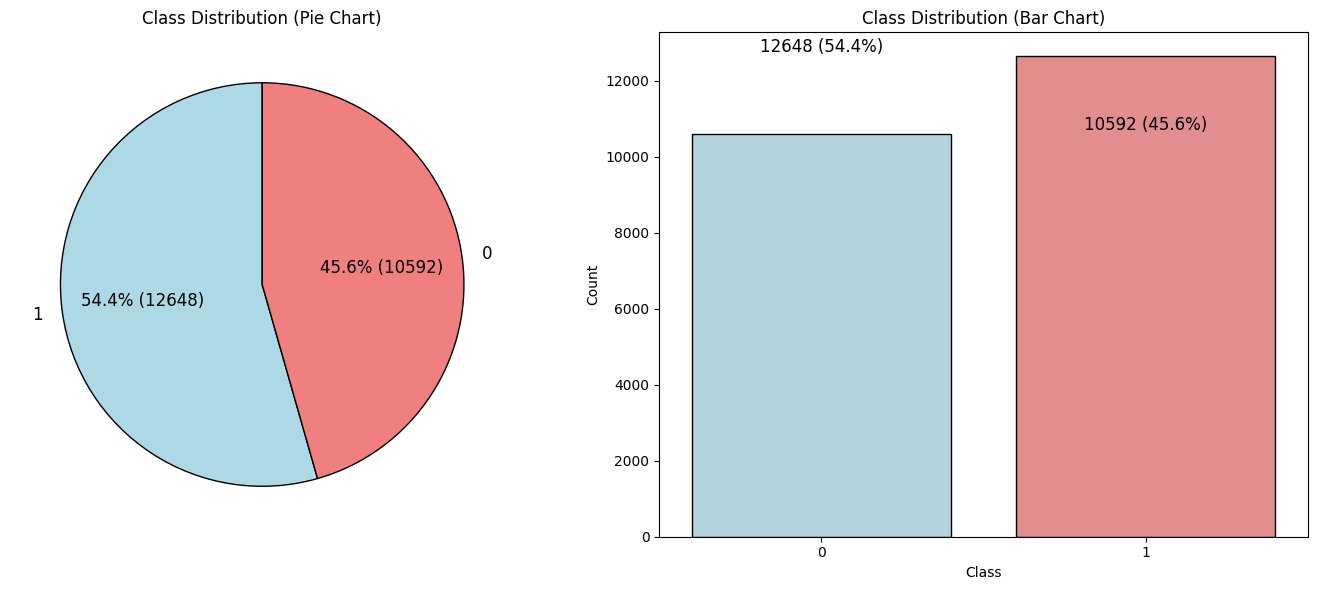

In [4]:
# Quan sát phân bổ của cột 'label'
label_counts = corpus['label'].value_counts()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['lightblue', 'lightcoral']
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: f'{p:.1f}% ({int(p*sum(label_counts)/100)})',
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
sns.barplot(x=label_counts.index, y=label_counts, palette=colors, edgecolor='black')
for index, value in enumerate(label_counts):
    plt.text(index, value, f'{value} ({value/sum(label_counts)*100:.1f}%)', ha='center', va='bottom', fontsize=12)
plt.title('Class Distribution (Bar Chart)')
plt.ylabel('Count')
plt.xlabel('Class')

# plt.savefig('plots_and_graphs/org_class_distribution.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

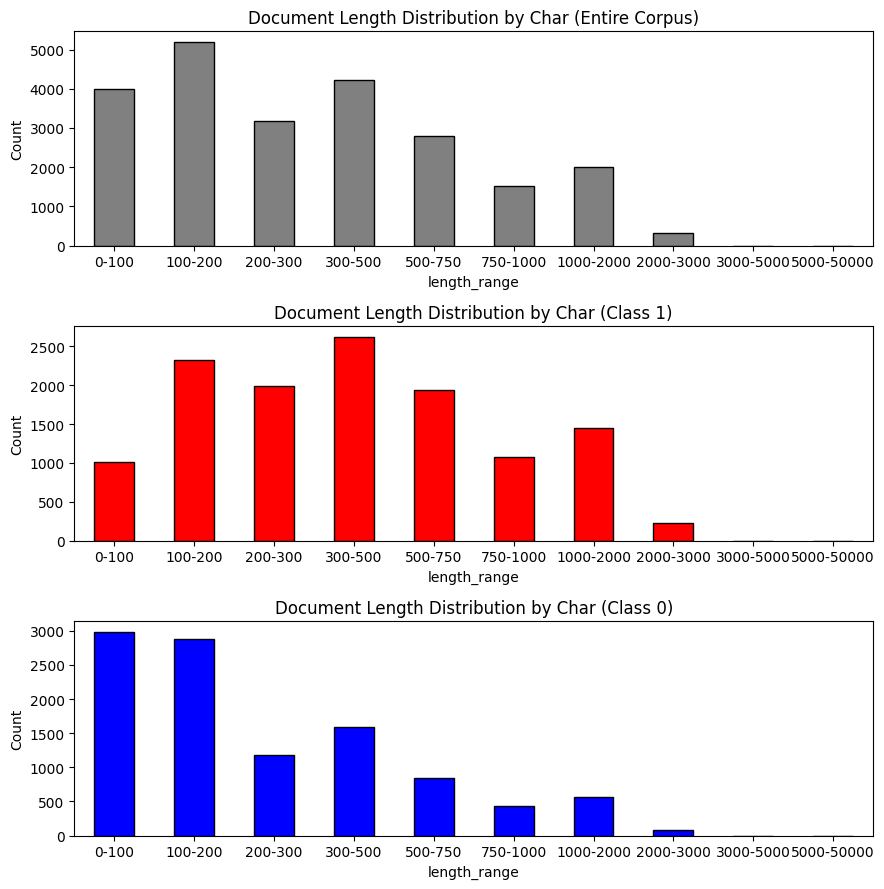

Entire Corpus (by char):
length_range
0-100         4005
100-200       5204
200-300       3171
300-500       4222
500-750       2794
750-1000      1515
1000-2000     2014
2000-3000      315
3000-5000        0
5000-50000       0
Name: count, dtype: int64

Class 1 (by char):
length_range
0-100         1017
100-200       2330
200-300       1984
300-500       2627
500-750       1945
750-1000      1075
1000-2000     1444
2000-3000      226
3000-5000        0
5000-50000       0
Name: count, dtype: int64

Class 0 (by char):
length_range
0-100         2988
100-200       2874
200-300       1187
300-500       1595
500-750        849
750-1000       440
1000-2000      570
2000-3000       89
3000-5000        0
5000-50000       0
Name: count, dtype: int64


In [5]:
# Quan sát phân bổ của độ dài theo char của các điểm dữ liệu
bins = [0, 100, 200, 300, 500, 750, 1000, 2000, 3000, 5000, 50000]
labels = ['0-100', '100-200', '200-300', '300-500', '500-750', '750-1000', '1000-2000', '2000-3000', '3000-5000', '5000-50000']

corpus['document_length'] = corpus['text'].apply(len)

corpus['length_range'] = pd.cut(corpus['document_length'], bins=bins, labels=labels, right=False)
class_1 = corpus[corpus['label'] == 1]
class_0 = corpus[corpus['label'] == 0]

total_counts = corpus['length_range'].value_counts().sort_index()
class_1_counts = class_1['length_range'].value_counts().sort_index()
class_0_counts = class_0['length_range'].value_counts().sort_index()

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
total_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Document Length Distribution by Char (Entire Corpus)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 2)
class_1_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title('Document Length Distribution by Char (Class 1)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 3)
class_0_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Document Length Distribution by Char (Class 0)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# plt.savefig('plots_and_graphs/org_char_length_distribution.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

print("Entire Corpus (by char):")
print(total_counts)
print("\nClass 1 (by char):")
print(class_1_counts)
print("\nClass 0 (by char):")
print(class_0_counts)

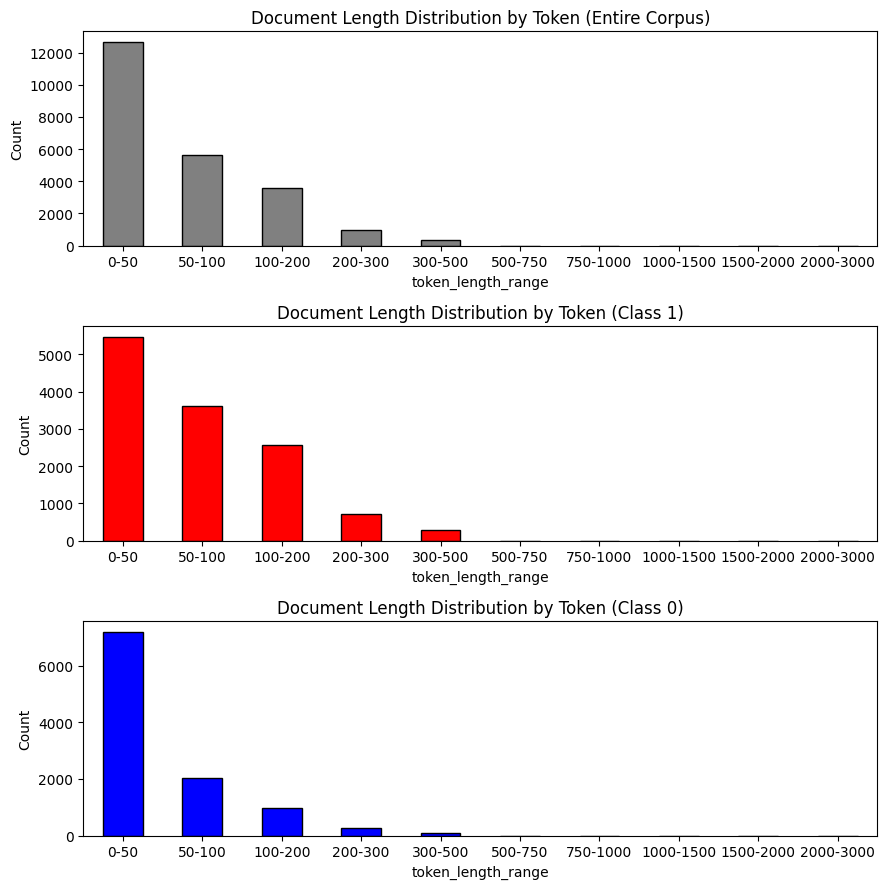

Entire Corpus (Token-based):
token_length_range
0-50         12692
50-100        5647
100-200       3564
200-300        978
300-500        359
500-750          0
750-1000         0
1000-1500        0
1500-2000        0
2000-3000        0
Name: count, dtype: int64

Class 1 (Token-based):
token_length_range
0-50         5480
50-100       3607
100-200      2577
200-300       712
300-500       272
500-750         0
750-1000        0
1000-1500       0
1500-2000       0
2000-3000       0
Name: count, dtype: int64

Class 0 (Token-based):
token_length_range
0-50         7212
50-100       2040
100-200       987
200-300       266
300-500        87
500-750         0
750-1000        0
1000-1500       0
1500-2000       0
2000-3000       0
Name: count, dtype: int64


In [6]:
# Quan sát phân bổ của độ dài theo tokens của các điểm dữ liệu
token_bins = [0, 50, 100, 200, 300, 500, 750, 1000, 1500, 2000, 3000]
token_labels = ['0-50', '50-100', '100-200', '200-300', '300-500', '500-750', '750-1000', '1000-1500', '1500-2000', '2000-3000']

corpus['token_length'] = corpus['text'].apply(lambda x: len(x.split()))

corpus['token_length_range'] = pd.cut(corpus['token_length'], bins=token_bins, labels=token_labels, right=False)

class_1_token = corpus[corpus['label'] == 1]
class_0_token = corpus[corpus['label'] == 0]

total_token_counts = corpus['token_length_range'].value_counts().sort_index()
class_1_token_counts = class_1_token['token_length_range'].value_counts().sort_index()
class_0_token_counts = class_0_token['token_length_range'].value_counts().sort_index()

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
total_token_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Document Length Distribution by Token (Entire Corpus)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 2)
class_1_token_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title('Document Length Distribution by Token (Class 1)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(3, 1, 3)
class_0_token_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Document Length Distribution by Token (Class 0)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# plt.savefig('plots_and_graphs/org_token_length_distribution.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

print("Entire Corpus (Token-based):")
print(total_token_counts)
print("\nClass 1 (Token-based):")
print(class_1_token_counts)
print("\nClass 0 (Token-based):")
print(class_0_token_counts)

In [7]:
# Dựa vào phương pháp tìm điểm dị thường, ta dựa vào độ dài của các văn bản để xác định có
# bao nhiêu văn bản có thể có là dị thường dựa vào độ dài
Q1 = corpus['document_length'].quantile(0.25)
Q3 = corpus['document_length'].quantile(0.75)

IQR = Q3 - Q1

lbound = Q1 - 1.5 * IQR
ubound = Q3 + 1.5 * IQR

print(f"Lower bound : {lbound}")
print(f"Upper bound : {ubound}")

outliers = corpus[(corpus['document_length'] < ubound) | (corpus['document_length'] > lbound)]

print(f"Number of outliers: {len(outliers)}")

mean_length_corpus = corpus['document_length'].mean()
mean_length_class_1 = corpus[corpus['label'] == 1]['document_length'].mean()
mean_length_class_0 = corpus[corpus['label'] == 0]['document_length'].mean()

print(f"Mean document length (Entire Corpus): {mean_length_corpus:.2f}")
print(f"Mean document length (Class 1): {mean_length_class_1:.2f}")
print(f"Mean document length (Class 0): {mean_length_class_0:.2f}")

Lower bound : -521.0
Upper bound : 1207.0
Number of outliers: 23240
Mean document length (Entire Corpus): 427.91
Mean document length (Class 1): 516.38
Mean document length (Class 0): 322.26


In [8]:
# Sử dụng Tokenizer để quan sát số Unique Tokens, Total Tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus['text'])

sequences = tokenizer.texts_to_sequences(corpus['text'])

total_tokens = sum(len(seq) for seq in sequences)
unique_tokens = len(tokenizer.word_index)

class_1_text = corpus[corpus['label'] == 1]['text']
class_0_text = corpus[corpus['label'] == 0]['text']

class_1_sequences = tokenizer.texts_to_sequences(class_1_text)
class_0_sequences = tokenizer.texts_to_sequences(class_0_text)

total_tokens_class_1 = sum(len(seq) for seq in class_1_sequences)
total_tokens_class_0 = sum(len(seq) for seq in class_0_sequences)

tokenizer_class_1 = Tokenizer()
tokenizer_class_1.fit_on_texts(class_1_text)
unique_tokens_class_1 = len(tokenizer_class_1.word_index)

tokenizer_class_0 = Tokenizer()
tokenizer_class_0.fit_on_texts(class_0_text)
unique_tokens_class_0 = len(tokenizer_class_0.word_index)

print(f"Unique Tokens (Total): {unique_tokens}")
print(f"Total Tokens (Total): {total_tokens}")
print(f"Unique Tokens (Class 1): {unique_tokens_class_1}")
print(f"Total Tokens (Class 1): {total_tokens_class_1}")
print(f"Unique Tokens (Class 0): {unique_tokens_class_0}")
print(f"Total Tokens (Class 0): {total_tokens_class_0}")

Unique Tokens (Total): 14470
Total Tokens (Total): 1560493
Unique Tokens (Class 1): 12088
Total Tokens (Class 1): 1033603
Unique Tokens (Class 0): 13657
Total Tokens (Class 0): 526890


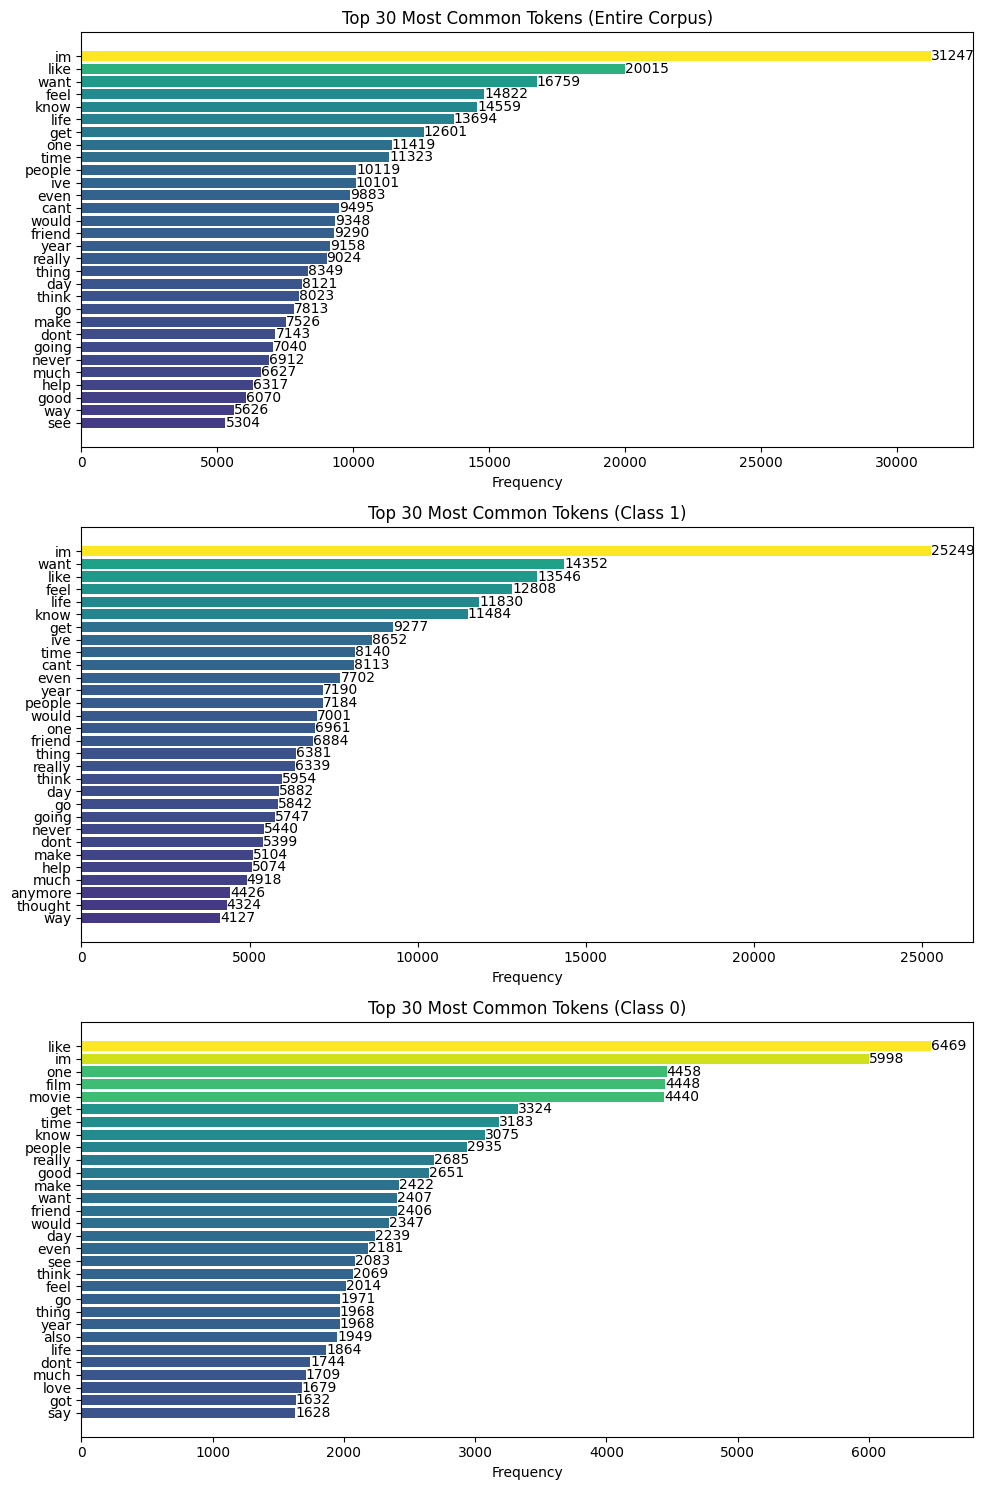

In [9]:
# Top 30 tokens có tần xuất cao nhất
def get_top_n_tokens(corpus, n=30):
    all_tokens = ' '.join(corpus['text']).split()
    token_counts = Counter(all_tokens)
    return token_counts.most_common(n)

top_tokens_corpus = get_top_n_tokens(corpus)
top_tokens_class_1 = get_top_n_tokens(corpus[corpus['label'] == 1])
top_tokens_class_0 = get_top_n_tokens(corpus[corpus['label'] == 0])

def prepare_plot_data(top_tokens):
    words, counts = zip(*top_tokens)
    return list(words), list(counts)

words_corpus, counts_corpus = prepare_plot_data(top_tokens_corpus)
words_class_1, counts_class_1 = prepare_plot_data(top_tokens_class_1)
words_class_0, counts_class_0 = prepare_plot_data(top_tokens_class_0)

def plot_top_tokens(words, counts, title, ax):
    bars = ax.barh(words, counts, color=cm.viridis(counts/np.max(counts)))
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.invert_yaxis()
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', va='center')

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

plot_top_tokens(words_corpus, counts_corpus, 'Top 30 Most Common Tokens (Entire Corpus)', axs[0])

plot_top_tokens(words_class_1, counts_class_1, 'Top 30 Most Common Tokens (Class 1)', axs[1])

plot_top_tokens(words_class_0, counts_class_0, 'Top 30 Most Common Tokens (Class 0)', axs[2])

# plt.savefig('plots_and_graphs/org_top_30_most_common.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

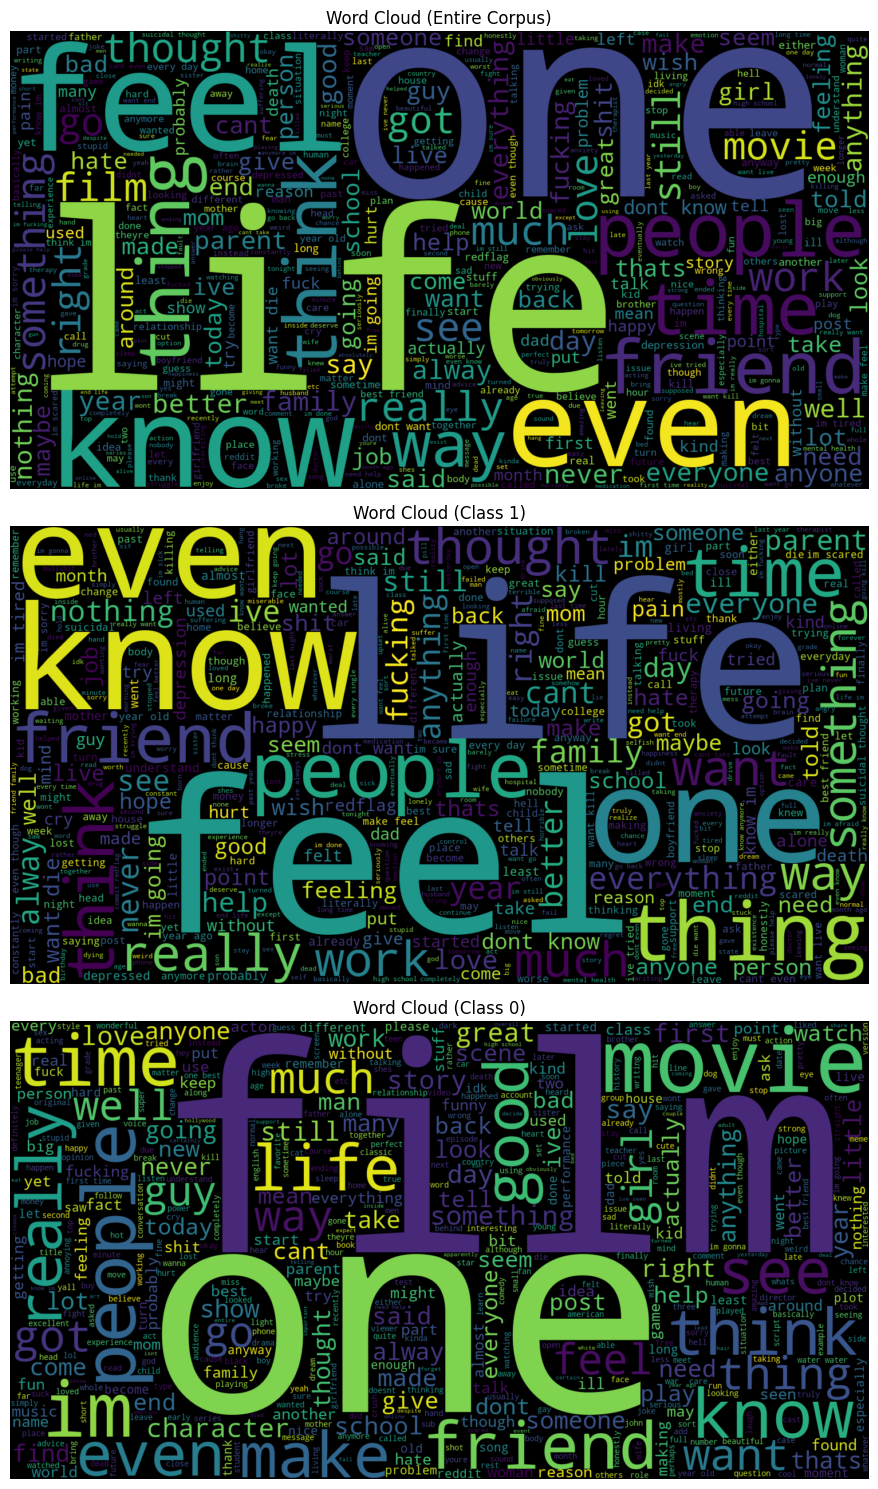

In [10]:
# Trực quan hóa bằng phương pháp Word Cloud
def create_word_cloud(text, title, ax):
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500, background_color='black', colormap='viridis').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

text_corpus = ' '.join(corpus['text'])
text_class_1 = ' '.join(corpus[corpus['label'] == 1]['text'])
text_class_0 = ' '.join(corpus[corpus['label'] == 0]['text'])

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

create_word_cloud(text_corpus, 'Word Cloud (Entire Corpus)', axs[0])

create_word_cloud(text_class_1, 'Word Cloud (Class 1)', axs[1])

create_word_cloud(text_class_0, 'Word Cloud (Class 0)', axs[2])

# plt.savefig('plots_and_graphs/org_word_clouds.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

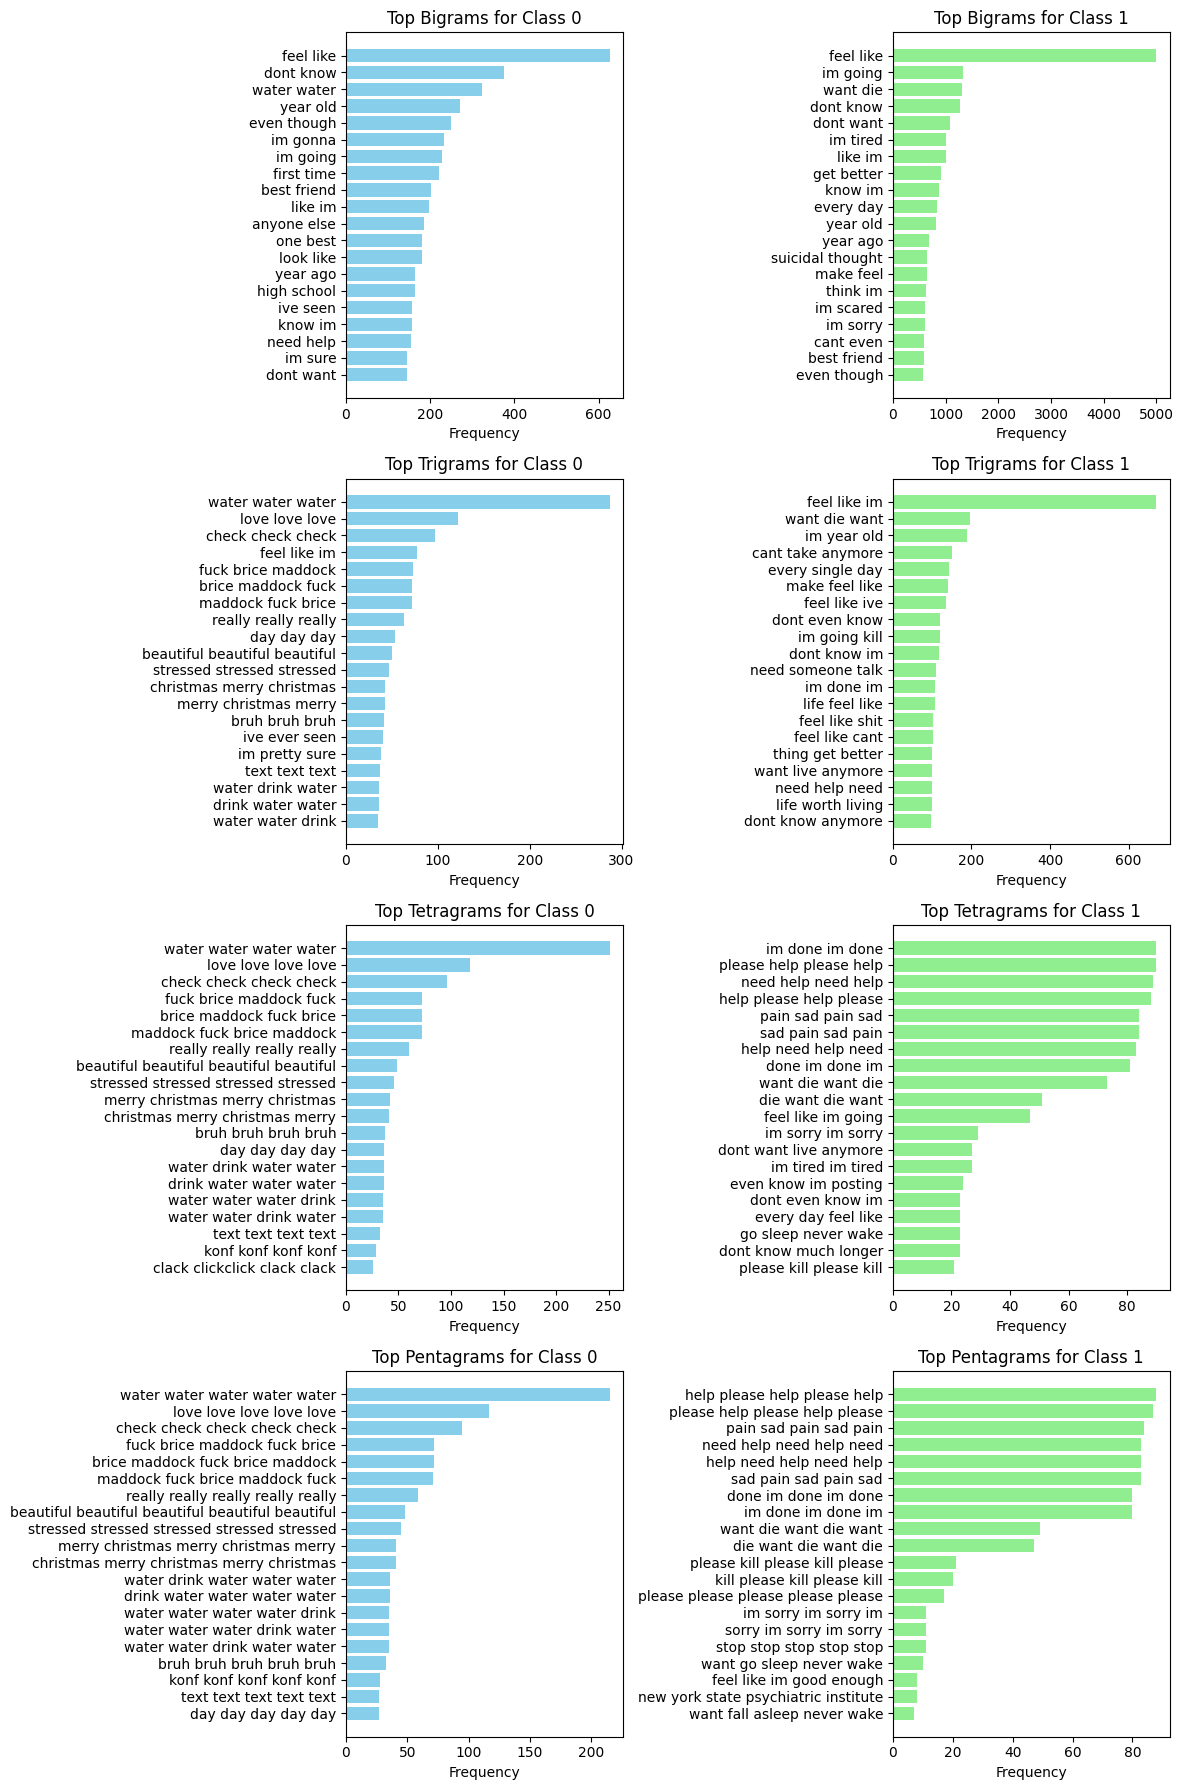

In [11]:
# Thực hiện phân tích n-grams với n = 2, 3, 4, 5
k = 20

def get_top_ngrams_with_tokenizer(corpus, n=2, top_k=10):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)

    ngrams = []
    for seq in sequences:
        for i in range(len(seq) - n + 1):
            ngrams.append(tuple(seq[i:i + n]))

    ngram_freq = Counter(ngrams)
    return ngram_freq.most_common(top_k), tokenizer

ngram_results = {}

for n in range(2, 6):
    ngram_results[n] = {
        'class_0': get_top_ngrams_with_tokenizer(corpus[corpus['label'] == 0]['text'], n=n, top_k=k),
        'class_1': get_top_ngrams_with_tokenizer(corpus[corpus['label'] == 1]['text'], n=n, top_k=k)
    }

ngram_dfs = {}
for n in ngram_results:
    class_0_ngrams, tokenizer_0 = ngram_results[n]['class_0']
    class_1_ngrams, tokenizer_1 = ngram_results[n]['class_1']
    
    class_0_df = pd.DataFrame(class_0_ngrams, columns=['ngram', 'frequency'])
    class_0_df['ngram'] = class_0_df['ngram'].apply(lambda x: ' '.join([word for idx in x for word, word_idx in tokenizer_0.word_index.items() if idx == word_idx]))
    class_0_df['class'] = 0
    
    class_1_df = pd.DataFrame(class_1_ngrams, columns=['ngram', 'frequency'])
    class_1_df['ngram'] = class_1_df['ngram'].apply(lambda x: ' '.join([word for idx in x for word, word_idx in tokenizer_1.word_index.items() if idx == word_idx]))
    class_1_df['class'] = 1
    
    combined_df = pd.concat([class_0_df, class_1_df], ignore_index=True)
    ngram_dfs[n] = combined_df

fig, axs = plt.subplots(4, 2, figsize=(12, 18))

titles = [
    'Top Bigrams for Class 0',
    'Top Bigrams for Class 1',
    'Top Trigrams for Class 0',
    'Top Trigrams for Class 1',
    'Top Tetragrams for Class 0',
    'Top Tetragrams for Class 1',
    'Top Pentagrams for Class 0',
    'Top Pentagrams for Class 1'
]

for i, n in enumerate(range(2, 6)):
    class_0_data = ngram_dfs[n][ngram_dfs[n]['class'] == 0]
    axs[i, 0].barh(class_0_data['ngram'], class_0_data['frequency'], color='skyblue')
    axs[i, 0].set_title(titles[i * 2])
    axs[i, 0].set_xlabel('Frequency')
    axs[i, 0].invert_yaxis()

    class_1_data = ngram_dfs[n][ngram_dfs[n]['class'] == 1]
    axs[i, 1].barh(class_1_data['ngram'], class_1_data['frequency'], color='lightgreen')
    axs[i, 1].set_title(titles[i * 2 + 1])
    axs[i, 1].set_xlabel('Frequency')
    axs[i, 1].invert_yaxis()

# plt.savefig('plots_and_graphs/org_n_grams_analysis.png', format='png', dpi=300)

plt.tight_layout()
plt.show()

In [12]:
from collections import Counter
import pandas as pd
import re

# Tính toán từ ít xuất hiện nhất theo tần suất
k = 300

def get_least_common_n_tokens(corpus, min_freq, max_freq, n=20):
    all_tokens = ' '.join(corpus['text']).split()
    token_counts = Counter(all_tokens)
    least_common = [(word, freq) for word, freq in token_counts.items() if min_freq <= freq < max_freq]
    return sorted(least_common, key=lambda x: x[1])[:n]

ranges = [(0, 5)]

for min_freq, max_freq in ranges:
    least_common_tokens = get_least_common_n_tokens(corpus, min_freq, max_freq, k)

    least_common_words = pd.DataFrame(least_common_tokens, columns=['word', 'frequency'])
    
    least_common_words['class'] = least_common_words['word'].apply(
        lambda x: corpus.loc[corpus['text'].str.contains(r'\b' + re.escape(x) + r'\b', na=False), 'label'].mode().get(0, None)
    )
    
    print(f"\nTop {k} Least Common Words with Frequency from {min_freq} to {max_freq}:")
    for _, row in least_common_words.iterrows():
        print(f"Word: '{row['word']}', Frequency: {row['frequency']}, Class: {row['class']}")

    class_counts = least_common_words['class'].value_counts()
    print(f"\nClass counts for frequency range {min_freq} to {max_freq}:")
    print(f"Class 0 Instances: {class_counts.get(0, 0)}")
    print(f"Class 1 Instances: {class_counts.get(1, 0)}")


Top 300 Least Common Words with Frequency from 0 to 5:
Word: 'consented', Frequency: 1, Class: 1
Word: 'blanc', Frequency: 1, Class: 0
Word: 'img', Frequency: 1, Class: 0
Word: 'pita', Frequency: 1, Class: 0
Word: 'raced', Frequency: 1, Class: 1
Word: 'doomsday', Frequency: 1, Class: 0
Word: 'obamas', Frequency: 1, Class: 0
Word: 'lindsay', Frequency: 1, Class: 0
Word: 'uworstestgrammar', Frequency: 1, Class: 0
Word: 'rationale', Frequency: 1, Class: 0
Word: 'harley', Frequency: 1, Class: 0
Word: 'unvaccinated', Frequency: 1, Class: 0
Word: 'poppin', Frequency: 1, Class: 0
Word: 'checkpoint', Frequency: 1, Class: 0
Word: 'shank', Frequency: 1, Class: 0
Word: 'eustache', Frequency: 1, Class: 0
Word: 'sho', Frequency: 1, Class: 0
Word: 'persist', Frequency: 1, Class: 1
Word: 'exfiance', Frequency: 1, Class: 1
Word: 'asteroid', Frequency: 1, Class: 1
Word: 'sacrificing', Frequency: 1, Class: 1
Word: 'magnesium', Frequency: 1, Class: 1
Word: 'redbull', Frequency: 1, Class: 1
Word: 'shortt

In [13]:
# Tính toán 50 từ dài nhất
def get_longest_n_words(corpus, n=50):
    all_tokens = ' '.join(corpus['text']).split()
    unique_words = set(all_tokens)
    longest_words = sorted(unique_words, key=len, reverse=True)
    return longest_words[:n]

longest_words = get_longest_n_words(corpus)

print("Top 50 Longest Words:")
for word in longest_words:
    rows_with_word = corpus[corpus['text'].str.contains(r'\b' + re.escape(word) + r'\b', na=False)].index.tolist()
    truncated_word = word if len(word) <= 20 else word[:70] + '...'
    print(f"Word: {truncated_word}, Found in rows: {rows_with_word}")

Top 50 Longest Words:
Word: institutionalized, Found in rows: [770, 2555, 3006, 3330, 4128, 4533, 10071, 10122, 12642, 15268, 15935]
Word: passiveaggressive, Found in rows: [3299, 6476, 7218, 15644, 17841, 23109]
Word: depressionanxiety, Found in rows: [1931, 4021, 8772, 12180, 13178, 15854, 16478, 19890, 20209, 21226, 21769, 22951]
Word: depersonalization, Found in rows: [1640, 6886, 7016, 8500, 13719, 14243, 17941, 19506, 21921, 22853]
Word: depressionredflag, Found in rows: [682, 3194, 5849, 8867, 15785, 20113, 20656, 23102]
Word: anxietydepression, Found in rows: [2556, 6859, 13937, 14927]
Word: incomprehensible, Found in rows: [1281, 3390, 4167, 7134, 7841, 7901, 11263, 16876, 19204]
Word: underappreciated, Found in rows: [5252, 12220, 12269, 13915, 15015]
Word: extraterrestrial, Found in rows: [10465, 11713, 15630, 23058]
Word: enthusiastically, Found in rows: [1435, 3305, 6395, 15068]
Word: characterisation, Found in rows: [1198, 4839, 13861, 22956, 23118]
Word: characterization

In [14]:
# Tính toán độ dài ký tự tối đa và trung bình của các từ
all_tokens = ' '.join(corpus['text']).split()
char_lengths = [len(word) for word in all_tokens]

max_length = max(char_lengths)
mean_length = sum(char_lengths) / len(char_lengths)

print(f"Maximum character length of a word: {max_length}")
print(f"Mean character length of words: {mean_length:.2f}")

Maximum character length of a word: 17
Mean character length of words: 5.39


In [15]:
# Đếm số lượng liên kết và in ra một số ví dụ
links = corpus[corpus['text'].str.contains(r'(http|www)', na=False)]

# Print the number of links and a few examples with original row indices
num_links = len(links)
print(f"Total number of links found: {num_links}")

print("Examples of links:")
for index in links.index[:5]:
    print(f"Link in row {index}: {links.loc[index]['text']}")

Total number of links found: 0
Examples of links:


In [16]:
def clean_repeated_characters(corpus):
    modified_corpus = corpus.copy()
    changes_printed = 0  # Counter for printed changes
    max_changes_to_print = 5  # Maximum changes to print

    for index, row in modified_corpus.iterrows():
        original_text = row['text']
        # Replace characters that are repeated 3 or more times with a single instance
        modified_text = re.sub(r'(.)\1{2,}', r'\1', original_text)
        modified_corpus.at[index, 'text'] = modified_text

        # Print out examples of changes, only if the original text is less than 400 characters
        if original_text != modified_text and len(original_text) < 400:
            print(f"Row {index}: '{original_text}' -> '{modified_text}'")
            changes_printed += 1
            
            if changes_printed >= max_changes_to_print:  # Stop after printing the max number
                break
    
    return modified_corpus

# Apply the cleaning function
cleaned_corpus = clean_repeated_characters(corpus)

In [17]:
# Find all tokens that end with the letter 'i'
tokens_ending_with_i = [token for text in corpus['text'] for token in text.split() if token.endswith('i')]

# Count the frequency of these tokens
token_freq_ending_with_i = Counter(tokens_ending_with_i)

# Sort tokens by frequency in descending order
sorted_tokens_ending_with_i = token_freq_ending_with_i.most_common()

# Print the total count and the sorted tokens with their frequencies
print(f"Total number of tokens ending with 'i': {len(tokens_ending_with_i)}")
print("Tokens that end with 'i' by frequency (highest to lowest):")
for token, freq in sorted_tokens_ending_with_i:
    print(f"{token}: {freq}")

Total number of tokens ending with 'i': 0
Tokens that end with 'i' by frequency (highest to lowest):


# Tóm tắt phần phân tích bộ dữ liệu sau khi dọn

### Chúng ta đã quan sát:
